In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))],)


batch_size = 32

# Load the trainset
trainset = torchvision.datasets.STL10(root='./data', 
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load the testset
testset = torchvision.datasets.STL10(root='./data', 
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('airplane' , 'bird' , 'car' , 'cat' , 'deer' , 'dog' , 'horse' , 'monkey' , 'ship' , 'truck')

Files already downloaded and verified
Files already downloaded and verified


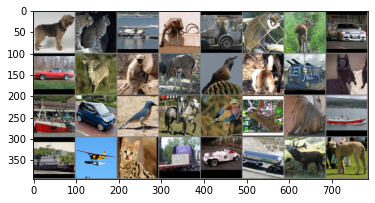

dog   cat   airplane monkey truck monkey deer  car   car   deer  monkey deer  bird  dog   car   dog   ship  car   bird  horse bird  deer  monkey ship  ship  airplane cat   truck car   truck deer  dog  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 21 * 21, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_1 = Net()
net_1 = net_1.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_1.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 20
all_acc_1 = []
train_acc_1 = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net_1.to('cuda')
    net_1.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_1.append(train_acc.cpu().item())
    print(f"Accuracy of the network in {epoch + 1}th epoch on the 50000 train images: {train_acc:.5f}")
            
    net_1.eval()
    net_1.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_1(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_1.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 50000 train images: 0.11425
Accuracy of the network in 1th epoch on the 10000 test images: 11 %
Accuracy of the network in 2th epoch on the 50000 train images: 0.18611
Accuracy of the network in 2th epoch on the 10000 test images: 26 %
Accuracy of the network in 3th epoch on the 50000 train images: 0.29061
Accuracy of the network in 3th epoch on the 10000 test images: 31 %
Accuracy of the network in 4th epoch on the 50000 train images: 0.31310
Accuracy of the network in 4th epoch on the 10000 test images: 33 %
Accuracy of the network in 5th epoch on the 50000 train images: 0.34813
Accuracy of the network in 5th epoch on the 10000 test images: 37 %
Accuracy of the network in 6th epoch on the 50000 train images: 0.37480
Accuracy of the network in 6th epoch on the 10000 test images: 39 %
Accuracy of the network in 7th epoch on the 50000 train images: 0.40247
Accuracy of the network in 7th epoch on the 10000 test images: 43 %
Accuracy of the netw

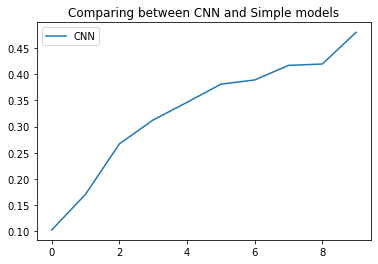

In [6]:
plt.plot(all_acc_1)
plt.legend(['CNN','0 Hidden','1 Hidden','2 Hidden','3 Hidden','4 Hidden'])
plt.title('Comparing between CNN and Simple models')
plt.show()